In [36]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import multiprocessing
import itertools

Import $D$ criteria functions from Dcriteria.py:

In [2]:
from Dcriteria import calcDSH, calcDH, calcDD

Read in EMCCD data:

In [3]:
# Read in EMCCD data
emccd_meteors_raw = pd.read_json('solution_table.json')

Filter out showers so we only have sporadics:

In [4]:
emccd_sporadic_mask = emccd_meteors_raw.shower_no == -1  # compute this since we also need to filter impact probabilities by this
emccd_meteors_sporadic = emccd_meteors_raw[emccd_sporadic_mask]  # not associated with a shower

Get raw orbital elements:

In [23]:
# for EMCCD fireballs
emccd_as_raw, emccd_es_raw, emccd_is_raw, emccd_omegas_raw, emccd_nodes_raw, emccd_ms_raw, emccd_qs_raw, emccd_masses_raw = np.array(emccd_meteors_sporadic[['a', 'e', 'i', 'omega', 'asc_node', 'mean_anomaly', 'q', 'mass']]).T

Select asteroidal meteors based on the definition of Borovicka et al. 2022 and impose minimum mass cutoff of $10$ g = $10^{-2}$ kg and  $0.01$ g = $10^{-5}$ kg as suggested by Peter:

In [32]:
sma_jupiter = 5.20336301  # SMA of jupiter in AU
# mass_min = 1.e-2  # 1e-2 kg = 10g
mass_min = 1.e-5  # 1e-5 kg = 0.01g
tisserand_cutoff = 'borovicka'  # either a number to filter by tisserand parameter or 'borovicka' to use the borovicka criteria
# tisserand_cutoff = 3.0

#### ASTEROIDAL
emccd_Qs_raw = emccd_as_raw * (1. + (emccd_es_raw))
emccd_tjs_raw = (sma_jupiter/emccd_as_raw) + 2. * np.cos(np.deg2rad(emccd_is_raw)) * np.sqrt((emccd_as_raw/sma_jupiter) * (1. - emccd_es_raw ** 2))
# mask based on criteria of borovicka et al 2022
emccd_tisserand_mask = (emccd_Qs_raw.T < 4.9) | (emccd_is_raw.T > 40.) | (emccd_es_raw.T > 0.9) if tisserand_cutoff == 'borovicka' else (emccd_tjs_raw > tisserand_cutoff) | (emccd_Qs_raw.T < 4.9)

#### MASS THRESHOLD
mass_threshold_mask = emccd_masses_raw > mass_min

# filter by the masks
emccd_meteors = emccd_meteors_sporadic[emccd_tisserand_mask & mass_threshold_mask]
# get orbital parameters of filtered objects
emccd_as, emccd_es, emccd_is, emccd_omegas, emccd_nodes, emccd_ms, emccd_qs, emccd_masses = np.array(emccd_meteors[['a', 'e', 'i', 'omega', 'asc_node', 'mean_anomaly', 'q', 'mass']]).T

$101631$ sporadic asteroidal EMCCD meteors when using the definition of Borovicka et al. 2022:

$3463$ more massive than $0.01$ g = $10^{-5}$ kg

Compute the $D$-criteria of all $n$ choose $2$ meteors using both DSH (Southworth & Hawkins 1963) and DH (Jopek 1993):

In [49]:
# assemble in the format taken by the calcDSH() and calcDH() functions:
emccd_elems = np.c_[emccd_qs, emccd_es, emccd_is, emccd_nodes, emccd_omegas]

pairs = [(*emccd_elems[x1], *emccd_elems[x2]) for (x1, x2) in itertools.combinations(range(0, len(emccd_elems)), r=2)]
with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
    dsh_results = np.array(list(tqdm(pool.starmap(calcDSH, pairs))))
    dh_results = np.array(list(tqdm(pool.starmap(calcDH, pairs))))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5994453/5994453 [00:01<00:00, 4985256.56it/s]


Plot DSH:

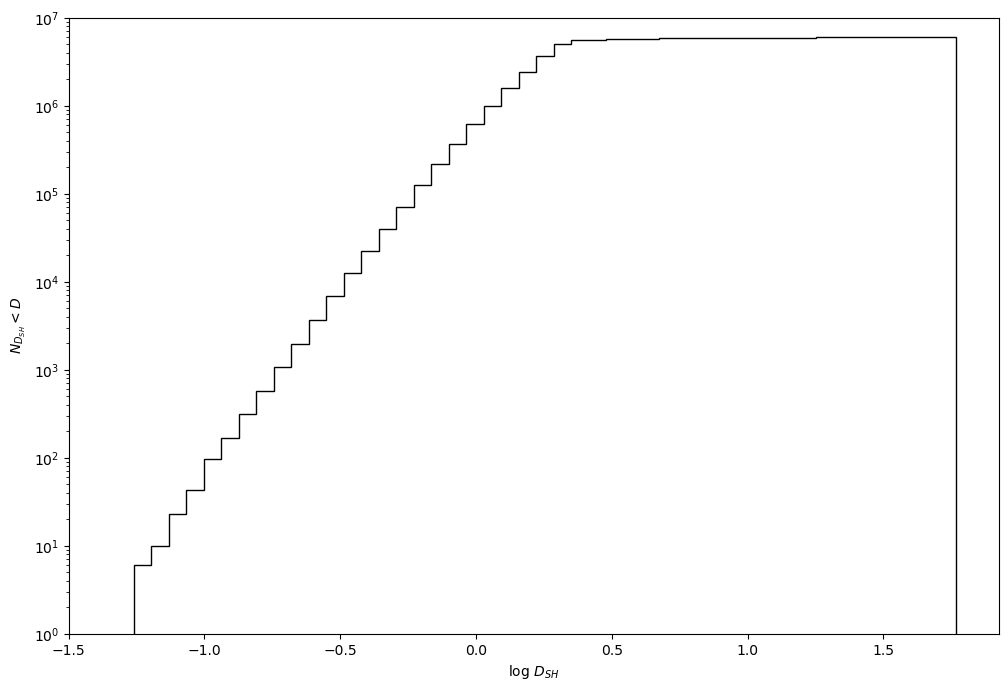

In [59]:
n_bins = 50
log10_dsh_results = np.log10(dsh_results)

plt.figure(figsize = (12, 8))
bins_dsh = np.linspace(np.min(log10_dsh_results), np.max(log10_dsh_results), n_bins)
entries_dsh, edges_dsh, _ = plt.hist(log10_dsh_results, bins=bins, color = 'k', cumulative=True, histtype='step')
plt.yscale('log')
# 
plt.xlim(left=-1.5), plt.ylim(1.e0, 1.e7)
plt.xlabel(r'log $D_{SH}$'), plt.ylabel(r'$N_{D_{SH}} < D$')
plt.savefig('emccd_dsh_min_mass.png')

and DH:

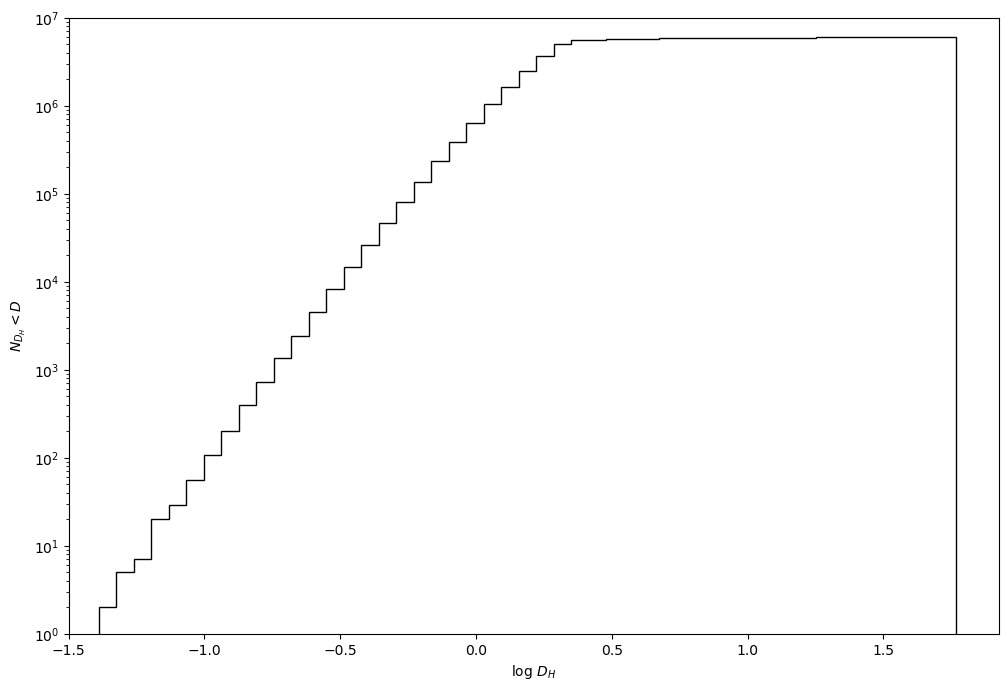

In [60]:
n_bins = 50
log10_dh_results = np.log10(dh_results)

plt.figure(figsize = (12, 8))
bins_dh = np.linspace(np.min(log10_dh_results), np.max(log10_dh_results), n_bins)
entries_dh, edges_dh, _ = plt.hist(log10_dh_results, bins=bins, color='k', cumulative=True, histtype='step')
plt.yscale('log')
# plt.xlim(-3, -0.35)
plt.xlim(left=-1.5), plt.ylim(1.e0, 1.e7)
plt.xlabel(r'log $D_{H}$'), plt.ylabel(r'$N_{D_{H}} < D$')
plt.savefig('emccd_dh_min_mass.png')

(-10.0, 0.0)

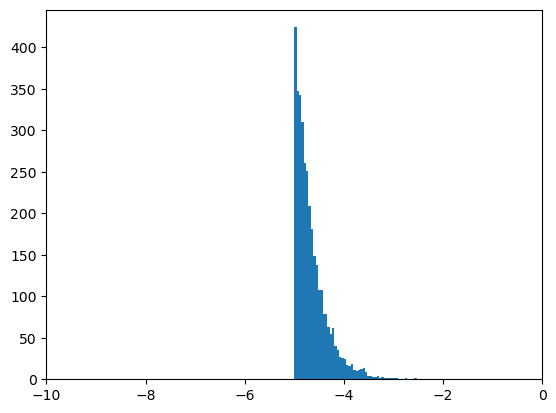

In [61]:
plt.hist(np.log10(emccd_masses[emccd_masses != 0]), bins='auto')
plt.xlim(-10, 0)